In [5]:
! pip install xgboost shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 105.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [shap]━━━━━━ 4/5 [shap]]te]


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# --- Load and merge ---
peptide_df = pd.read_csv("peptide_features.csv")
protein_df = pd.read_csv("protein_features.csv")
merged_df = pd.merge(peptide_df, protein_df, on="protein_id", suffixes=("_pep", "_prot"))

# --- Binarize labels ---
def binarize_presence(s):
    return s.replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1})

merged_df["presence_SILAC_bin"] = binarize_presence(merged_df["presence_SILAC"])
merged_df["presence_Label_free_bin"] = binarize_presence(merged_df["presence_Label_free"])

# --- Features ---
exclude_cols = [
    "protein_id", "peptide", "protein_sequence_pep", "protein_sequence_prot",
    "presence_SILAC", "presence_Label_free", "presence_SILAC_bin", "presence_Label_free_bin",
    "observed_frequency_SILAC", "observed_intensity_sum_SILAC",
    "observed_frequency_Label_free", "observed_intensity_sum_Label_free"
]
X = merged_df.drop(columns=[c for c in exclude_cols if c in merged_df.columns]).fillna(0)
y = merged_df["presence_SILAC_bin"].astype(int)
feature_names = X.columns.tolist()

# --- Split and scale ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Define models ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, eval_metric='logloss'),
    "SVM": SVC(kernel='rbf', C=2, probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# --- Fit and store models ---
fitted_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"{name:>18s} | Accuracy: {acc:.3f} | F1: {f1:.3f}")
    fitted_models[name] = model

print("\n✅ All models trained. You can now run the interpretability cell below.")


LogisticRegression | Accuracy: 0.820 | F1: 0.617
      RandomForest | Accuracy: 0.869 | F1: 0.731
           XGBoost | Accuracy: 0.881 | F1: 0.764
               SVM | Accuracy: 0.859 | F1: 0.710
               MLP | Accuracy: 0.847 | F1: 0.700

✅ All models trained. You can now run the interpretability cell below.


/home/mohammad/miniconda3/envs/gwas_py/envs/xaidll/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🔎 Interpreting LogisticRegression ...
                 Feature  Importance       Abs
2    MolecularWeight_pep   -2.637289  2.637289
1                pep_len    2.114324  2.114324
12        BomanIndex_pep   -1.460753  1.460753
7         Charge_pH7_pep   -1.228843  1.228843
13     PolarFraction_pep    1.053231  1.053231
3   IsoelectricPoint_pep   -0.795494  0.795494
11    AliphaticIndex_pep    0.425668  0.425668
5        Aromaticity_pep    0.384468  0.384468
23   AliphaticIndex_prot   -0.284046  0.284046
8      HelixFraction_pep   -0.193480  0.193480


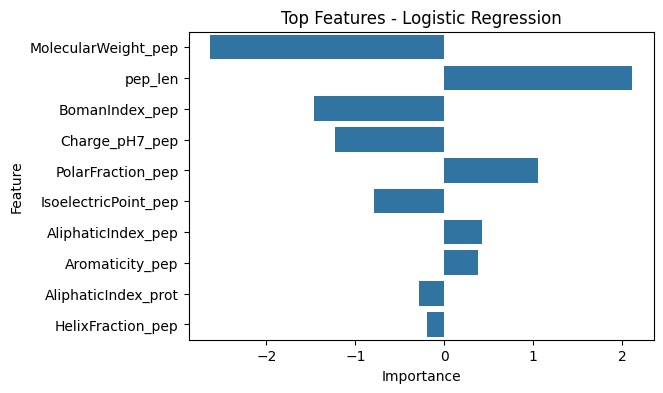


🔎 Interpreting RandomForest ...
                 Feature  Importance
3   IsoelectricPoint_pep    0.151043
2    MolecularWeight_pep    0.112475
7         Charge_pH7_pep    0.100424
12        BomanIndex_pep    0.084927
1                pep_len    0.047390
4     Hydrophobicity_pep    0.047367
13     PolarFraction_pep    0.045812
10     SheetFraction_pep    0.027444
11    AliphaticIndex_pep    0.026966
0             Unnamed: 0    0.024893


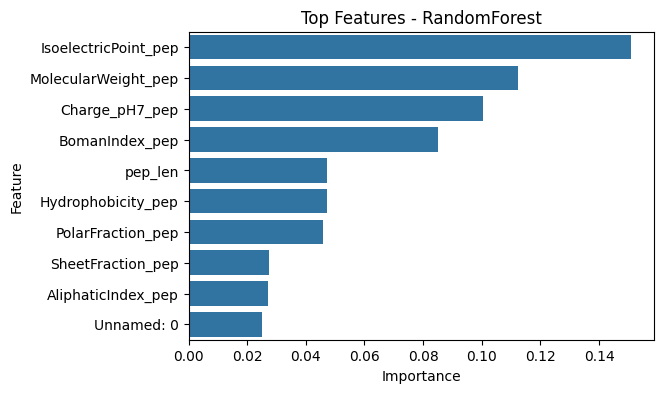


🔎 Interpreting XGBoost ...
                 Feature  Importance
3   IsoelectricPoint_pep    0.236450
2    MolecularWeight_pep    0.128423
12        BomanIndex_pep    0.113429
7         Charge_pH7_pep    0.078593
13     PolarFraction_pep    0.062657
9       TurnFraction_pep    0.024200
10     SheetFraction_pep    0.022620
14  MolecularWeight_prot    0.021277
25    PolarFraction_prot    0.021058
8      HelixFraction_pep    0.020754


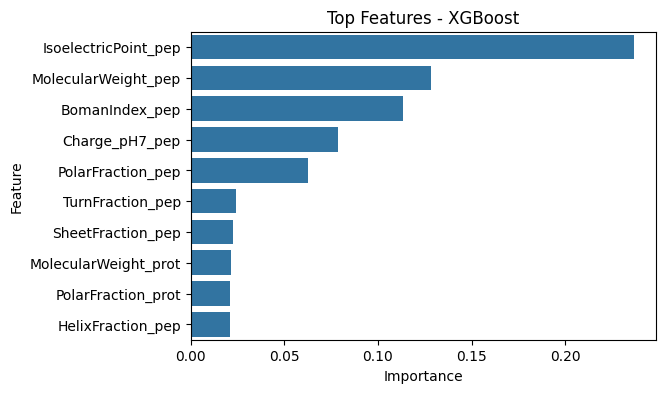


🔎 Interpreting SVM ...
(Using SHAP for complex models — may take a while)


100%|█████████████████████████████████████████| 50/50 [1:02:02<00:00, 74.45s/it]


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [6]:
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- interpret each model ---
def interpret_model(name, model, X_train_scaled, X_test_scaled, feature_names):
    print(f"\n🔎 Interpreting {name} ...")

    if name == "LogisticRegression":
        coef = model.coef_[0]
        imp_df = pd.DataFrame({"Feature": feature_names, "Importance": coef})
        imp_df["Abs"] = abs(imp_df["Importance"])
        imp_df = imp_df.sort_values("Abs", ascending=False)

        print(imp_df.head(10))
        plt.figure(figsize=(6,4))
        sns.barplot(x="Importance", y="Feature", data=imp_df.head(10))
        plt.title("Top Features - Logistic Regression")
        plt.show()

    elif name in ["RandomForest", "XGBoost"]:
        importances = model.feature_importances_
        imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
        imp_df = imp_df.sort_values("Importance", ascending=False)

        print(imp_df.head(10))
        plt.figure(figsize=(6,4))
        sns.barplot(x="Importance", y="Feature", data=imp_df.head(10))
        plt.title(f"Top Features - {name}")
        plt.show()

    else:
        print("(Using SHAP for complex models — may take a while)")
        explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train_scaled, 100))
        shap_values = explainer.shap_values(shap.sample(X_test_scaled, 50))
        shap.summary_plot(shap_values[1], shap.sample(X_test_scaled, 50), feature_names=feature_names, show=True)

# --- Run interpretability for all trained models ---
for name, model in fitted_models.items():
    interpret_model(name, model, X_train_scaled, X_test_scaled, feature_names)
